<a href="https://colab.research.google.com/github/gioliveirass/fatec-AM-carProduction/blob/main/car_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚗 Importando bibliotecas

Importando bibliotecas que serão utilizadas ao longo do desenvolvimento do script.

In [2]:
# Pandas
import pandas as pd

In [3]:
# Numpy
import numpy as np

In [4]:
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [5]:
# Sklearn
from sklearn.ensemble import RandomForestRegressor

In [6]:
# Skforecast
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 🚗 Carregando base de dados

A base de dados utilizada se encontra disponível no [Kaggle](https://www.kaggle.com/datasets/leonardobern/valor-da-produo-de-automveis-no-brasil?resource=download).

In [7]:
url = 'https://raw.githubusercontent.com/gioliveirass/fatec-AM-carProduction/main/dataset.csv'
data = pd.read_csv(url, sep=';')
data.head(5)

,data,valor
0,01/01/1993,66168
1,01/02/1993,73042
2,01/03/1993,98691
3,01/04/1993,88839
4,01/05/1993,101055


## 🚗 Ajustando dados
Definindo frequência de dados e analisando se há algum buraco nos dados.

In [10]:
# Converte data de string para datetime e transforma em índice
data['data'] = pd.to_datetime(data['data'], format='%d/%m/%Y')
sorted_data = data.set_index('data')
sorted_data = sorted_data.asfreq('MS')
sorted_data = sorted_data.sort_index()
sorted_data.head

<bound method NDFrame.head of              valor
data              
1993-01-01   66168
1993-02-01   73042
1993-03-01   98691
1993-04-01   88839
1993-05-01  101055
...            ...
2022-07-01  218950
2022-08-01  237961
2022-09-01  207762
2022-10-01  206044
2022-11-01  215796

[359 rows x 1 columns]>

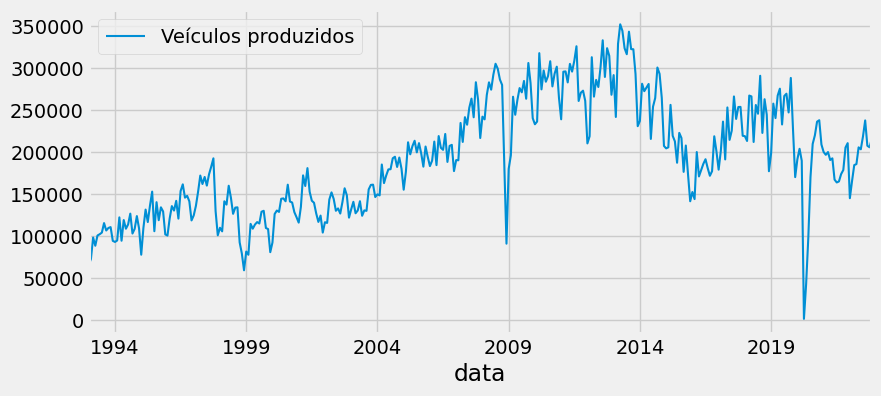

In [13]:
# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
sorted_data['valor'].plot(ax=ax, label='Veículos produzidos')
ax.legend();

In [14]:
print(f'Number of rows with missing values: {sorted_data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [15]:
# Código para verificar se não existem "buracos" nos dados
(sorted_data.index == pd.date_range(start=sorted_data.index.min(),
                             end=sorted_data.index.max(),
                             freq=sorted_data.index.freq)).all()

True

## 🚗 Separando dados de teste

Os dados de teste são os mais recentes. Quanto maior a quantidade de dados de teste, mais chances de diferença entre os dados de teste e os dados da predição.

In [68]:
# Divide dados em treinamento e teste
steps = 130
data_train = sorted_data[:-steps]
data_test  = sorted_data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1993-01-01 00:00:00 --- 2012-01-01 00:00:00  (n=229)
Test dates  : 2012-02-01 00:00:00 --- 2022-11-01 00:00:00  (n=130)


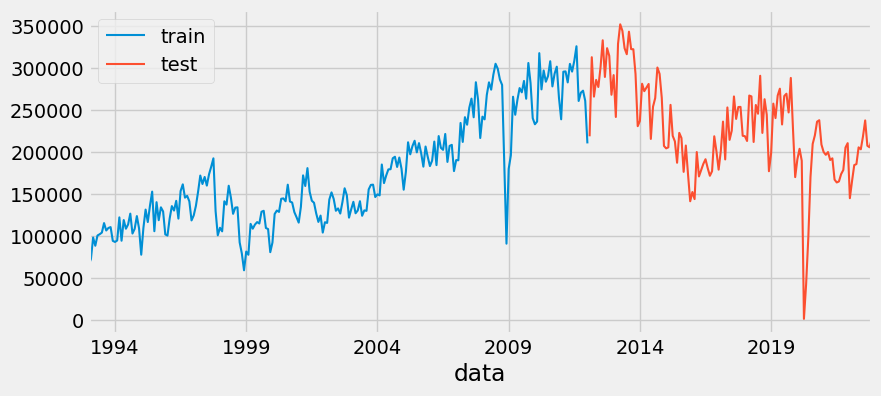

In [69]:
# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['valor'].plot(ax=ax, label='train')
data_test['valor'].plot(ax=ax, label='test')
ax.legend();

## 🚗 Configurando e realizando a predição
Adicionando configurações de predição e, por fim, realizando a predição.

In [73]:
# Configura e treina um RandomForestRegressor para série temporal
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 70
             )

forecaster.fit(y=data_train['valor'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] 
Transformer for y: None 
Transformer for exog: None 
Window size: 70 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1993-01-01 00:00:00'), Timestamp('2012-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_scor

In [74]:
# Faz predição no conjunto de teste
steps = 130
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2012-02-01    221865.544
2012-03-01    256780.360
2012-04-01    287710.780
2012-05-01    288298.640
2012-06-01    295032.170
Freq: MS, Name: pred, dtype: float64

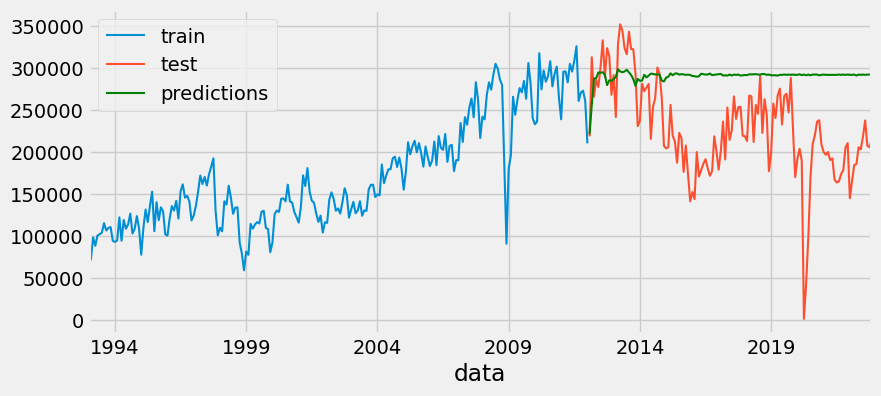

In [75]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['valor'].plot(ax=ax, label='train')
data_test['valor'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();